In [1]:
from pathlib import Path

file = Path('/Users/paddyharrison/Documents/Data/Dusseldorf/NiW/600C 24h/BLO/rec_-30deg_20211004_155329_000.blo')
assert file.exists()

from KED.io.res import ANG
file_ang = file.parents[1].joinpath('ANG', file.stem + ' (full) run3 1').with_suffix('.ang')
assert file_ang.exists()

ang = ANG.from_file(file_ang)

from orix.quaternion import Orientation
ori = Orientation.from_euler(ang.angles, direction='crystal2lab')
ori.shape

(92, 276)

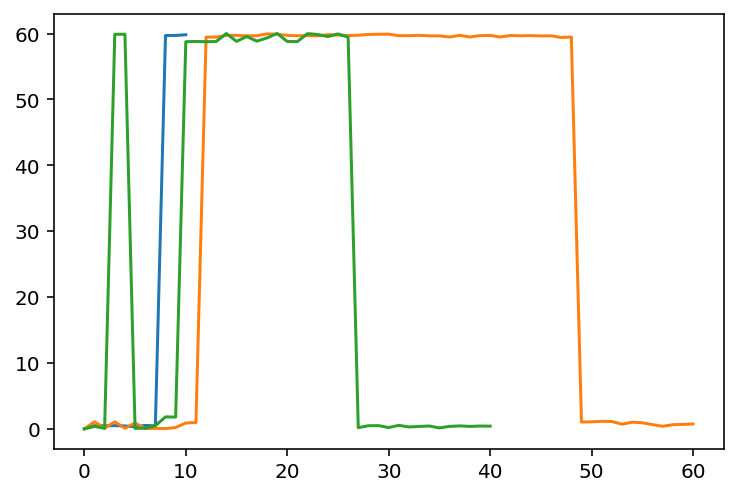

In [2]:
from skimage.draw import line
ij1 = line(65, 245, 55, 255)
# ax[0].plot(*ij1[::-1], color='k')

ij2 = line(20, 10, 20, 70)
# ax[0].plot(*ij2[::-1], color='k')

ij3 = line(70, 30, 65, 70)
# ax[0].plot(*ij3[::-1], color='k')

from orix.quaternion.symmetry import Oh
o1 = ori[ij1]
o1.symmetry = Oh

o2 = ori[ij2]
o2.symmetry = Oh

o3 = ori[ij3]
o3.symmetry = Oh

from matplotlib import pyplot as plt
import numpy as np
fig, ax = plt.subplots()
for o in (o1, o2, o3):
    ax.plot(np.rad2deg(o.angle_with(o[0]).data))

In [3]:
plt.close('all')
from KED.generator import CrystalDiffractionGenerator

import KED
from KED.generator import CrystalDiffractionGenerator
from KED.reciprocal_lattice import *

n_hkl = 25
max_angle = 5

cif = sorted(Path(KED.__file__).parent.joinpath('data', 'testing').glob('*.cif'))[2]
print(cif)

from ase import io as aseio
atoms = aseio.read(cif)

hkl = generate_hkl_points(n=n_hkl)
cell = atoms.get_cell().array


from orix.vector import Vector3d
o = Orientation.random()
cell_rot = (o * Vector3d(cell)).data

recip = reciprocal_vectors(*cell)
recip_rot = reciprocal_vectors(*cell_rot)

o * Vector3d(recip)

cif
generator = CrystalDiffractionGenerator(atoms, 200)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

from FourDimensionalData.blockfile import BLO
blo = BLO(file)

ps = 0.0252

for i, (ij, o) in enumerate(zip((ij1, ij2, ij3), (o1, o2, o3))):
    ij = np.column_stack(ij)
    frame_line_start = blo[tuple(ij[0])]
    frame_line_end = blo[tuple(ij[-1])]
    ax[i, 0].matshow(frame_line_start)
    ax[i, 1].matshow(frame_line_end)

    templates = generator.generate_templates(o[[0, -1]], s_max=0.05)
    templates[0].plot(ax[i, 0], ps, center=np.array(frame_line_start.shape)/2, size=50)
    templates[-1].plot(ax[i, -1], ps, center=np.array(frame_line_end.shape)/2, size=50)

/Users/paddyharrison/Documents/GitHub/KED/KED/data/testing/Ni.cif


In [4]:
from orix.io import loadang

a1 = loadang(file_ang).reshape(*ang.shape)
l1 = Orientation(a1[ij1])
l1.symmetry = Oh
np.rad2deg(l1.angle_with(l1[0]).data)

array([ 0.        ,  0.47434128,  0.47002014,  0.48870123,  0.43481822,
        0.31959992,  0.51540685,  0.45228238, 59.70736013, 59.71905401,
       59.81966493])

ValueError: [[3.52387 0.      0.     ]
 [0.      3.52387 0.     ]
 [0.      0.      3.52387]] is not a vector!

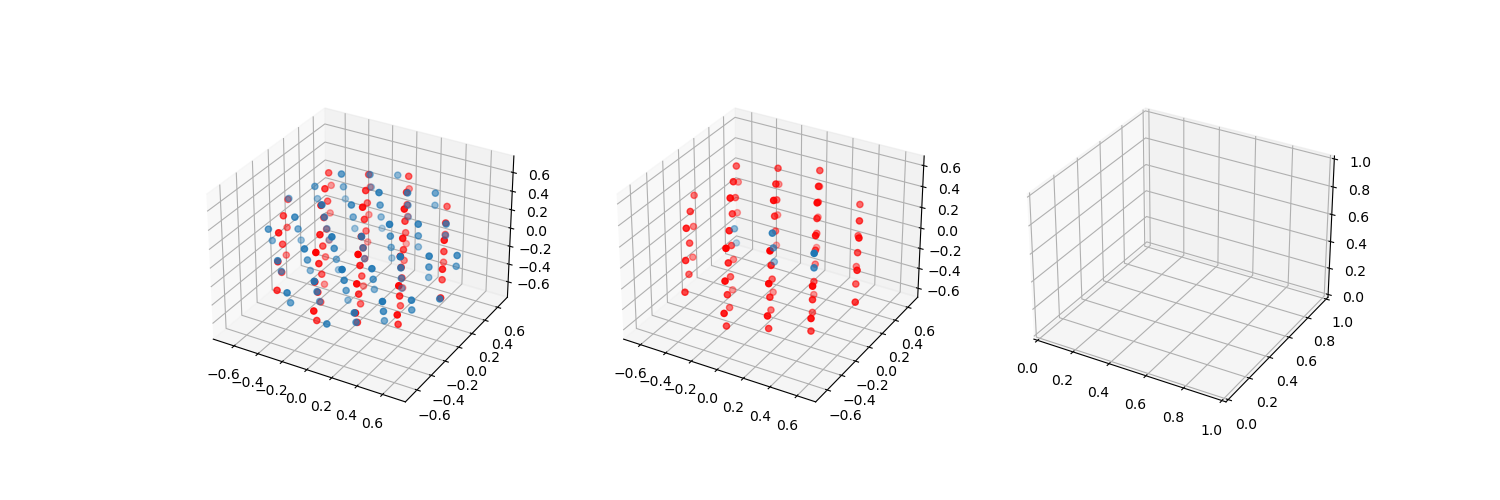

In [5]:
otwin1, otwin2 = o1[0], o1[-1]

np.rad2deg(otwin1.angle_with(otwin2).data)

hkl = generate_hkl_points(n=25)
recip = reciprocal_vectors(*cell)

g = calculate_g_vectors(hkl, recip)

from mpl_toolkits.mplot3d import Axes3D

from KED.microscope import *

plt.close('all')
max_angle = 1  # deg
w = electron_wavelength(200)
er = calculate_ewald_sphere_radius(wavelength=w)
mask = np.arctan(np.linalg.norm(g, axis=-1) / er) < np.deg2rad(max_angle)
g = g[mask]

g_twin1 = (~otwin1 * Vector3d(g)).data
g_twin2 = (~otwin2 * Vector3d(g)).data

%matplotlib widget
fig, ax = plt.subplots(ncols=3, subplot_kw=dict(projection='3d'), figsize=(15, 5))
ax[0].scatter(*g_twin1.T)
ax[0].scatter(*g_twin2.T, c='r')

from scipy.spatial import KDTree
tree = KDTree(g_twin1)
d, i = tree.query(g_twin2)

mask = d < 0.005

ax[1].scatter(*g_twin2[mask].T)
ax[1].scatter(*g_twin2[~mask].T, c='r')

(otwin2 * Vector3d(g_twin2[mask])).dot(np.linalg.inv(recip))

In [6]:
m = otwin2 - otwin1

from orix.vector import AxAngle
axis = AxAngle.from_rotation(m).axis

In [7]:
(otwin2 * Vector3d(g_twin2[mask])).data.dot(np.linalg.inv(recip))

array([[ 1.00000000e+00, -1.00000000e+00, -2.44517601e-17],
       [ 2.00000000e+00, -1.00000000e+00,  1.00000000e+00],
       [-1.00000000e+00,  0.00000000e+00, -1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-2.00000000e+00,  1.00000000e+00, -1.00000000e+00],
       [-1.00000000e+00,  1.00000000e+00,  2.44517601e-17]])

In [9]:
Orientation.from_euler(-np.array([[5.672495, 0.644201, 1.517215]])).to_euler()

array([[3.75228296, 0.644201  , 1.62437765]])

In [12]:
'(1, 2, 3)'.replace(' ', '')

'(1,2,3)'

Text(-3, -3, '(1, 2, -5)')

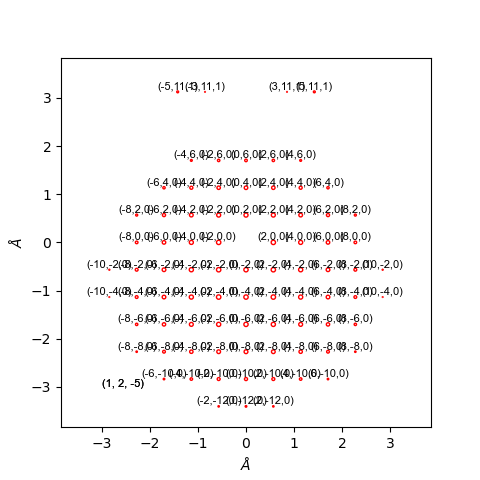

In [11]:
t = generator.generate_templates(Orientation.from_neo_euler(AxAngle(np.deg2rad((1, 0, 0)))), flip=False)
ax = t.plot(labels=True)

ax.text(-3, -3, (1, 2, -5), size=8, fontdict=dict(family='Arial'))
ax.text(-3, -3, (1, 2, -5), size=8, fontdict=dict(family='Arial'))

In [52]:
(~t.orientation * Vector3d(t.g)).data.dot(np.linalg.inv(reciprocal_vectors(*atoms.get_cell().array)))

array([[-4.,  8.,  0.],
       [-2.,  8.,  0.],
       [ 0.,  8.,  0.],
       [ 2.,  8.,  0.],
       [ 4.,  8.,  0.],
       [-6.,  6.,  0.],
       [-4.,  6.,  0.],
       [-2.,  6.,  0.],
       [ 0.,  6.,  0.],
       [ 2.,  6.,  0.],
       [ 4.,  6.,  0.],
       [ 6.,  6.,  0.],
       [-8.,  4.,  0.],
       [-6.,  4.,  0.],
       [-4.,  4.,  0.],
       [-2.,  4.,  0.],
       [ 0.,  4.,  0.],
       [ 2.,  4.,  0.],
       [ 4.,  4.,  0.],
       [ 6.,  4.,  0.],
       [ 8.,  4.,  0.],
       [-8.,  2.,  0.],
       [-6.,  2.,  0.],
       [-4.,  2.,  0.],
       [-2.,  2.,  0.],
       [ 0.,  2.,  0.],
       [ 2.,  2.,  0.],
       [ 4.,  2.,  0.],
       [ 6.,  2.,  0.],
       [ 8.,  2.,  0.],
       [-8.,  0.,  0.],
       [-6.,  0.,  0.],
       [-4.,  0.,  0.],
       [-2.,  0.,  0.],
       [ 2.,  0.,  0.],
       [ 4.,  0.,  0.],
       [ 6.,  0.,  0.],
       [ 8.,  0.,  0.],
       [-8., -2.,  0.],
       [-6., -2.,  0.],
       [-4., -2.,  0.],
       [-2., -2.

In [49]:
t.atoms is atoms

True

In [48]:
atoms

Atoms(symbols='Ni4', pbc=True, cell=[3.52387, 3.52387, 3.52387], spacegroup_kinds=...)

In [57]:
np.zeros_like(t.g, dtype=int).nbytes

1632